In [6]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline
fig_size = (12, 9)
plt.rcParams["figure.figsize"] = fig_size

In [7]:
plt.rcParams["figure.figsize"] = fig_size

## Camera Calibration

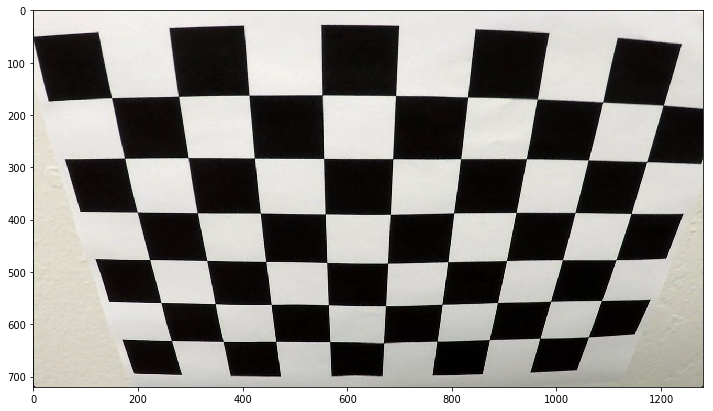

In [8]:
images = glob.glob('./camera_cal/calibration*.jpg')
img = mpimg.imread('./camera_cal/calibration2.jpg')
plt.imshow(img)


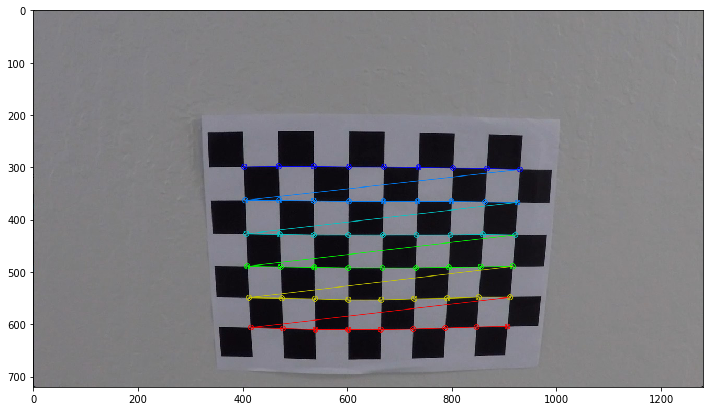

In [9]:
# Arrays to store objects points and image points
objpoints = []
imgpoints = []

# Object points
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

for image in images:
    #Import image and convert to grayscale
    img = mpimg.imread(image)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    #Detect chessboard corner
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    #If corners are found add object points, image points
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        plt.imshow(img)


In [10]:
#Saving calibration data
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)

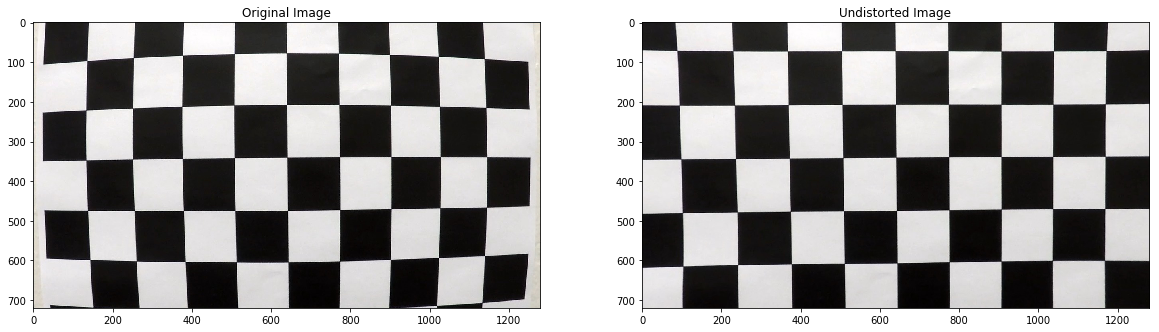

In [11]:
#Undistorting test img (image 1 was not used in calibration because all the corners couldnt be seen in the image)
img = mpimg.imread('./camera_cal/calibration1.jpg')
dst = cv2.undistort(img, mtx, dist, None, mtx)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Original Image')
ax1.imshow(img)

ax2.set_title('Undistorted Image')
ax2.imshow(dst)

## Detecting lane lines in test image

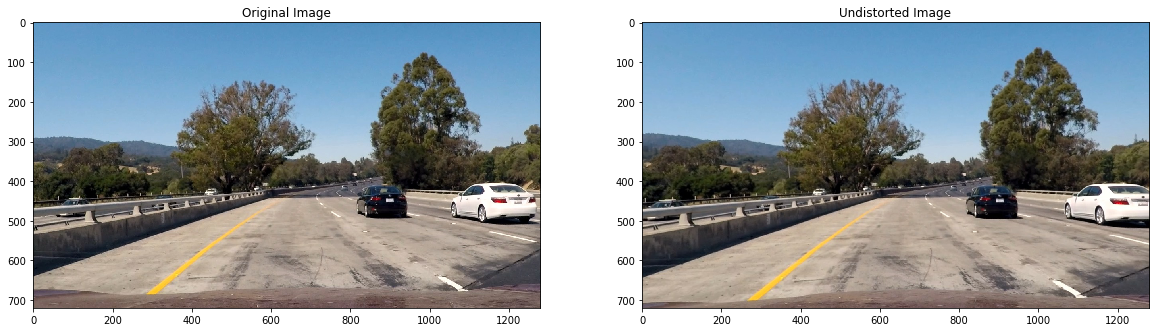

In [12]:
img = mpimg.imread('./test_images/test1.jpg')
def undistort_image(img, mtx, dist):
    #undistorting image
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

undist = undistort_image(img, mtx, dist)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Original Image')
ax1.imshow(img)

ax2.set_title('Undistorted Image')
ax2.imshow(undist)

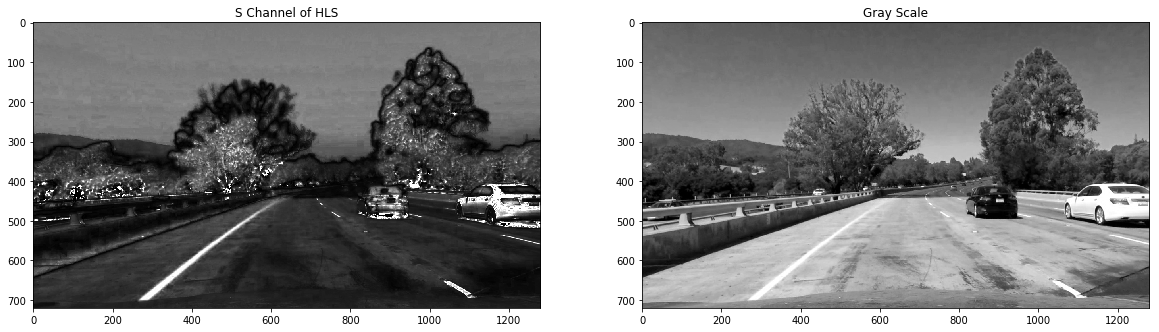

In [13]:
def convert_image(img):
    #Convert to HLS and separate S channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]

    #Convert also to grayscale in the R channel
    gray = img[:,:,0]
    
    return s_channel, gray

s_channel, gray = convert_image(undist)


# Plotting 2 images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('S Channel of HLS')
ax1.imshow(s_channel, cmap='gray')

ax2.set_title('Gray Scale')
ax2.imshow(gray, cmap='gray')

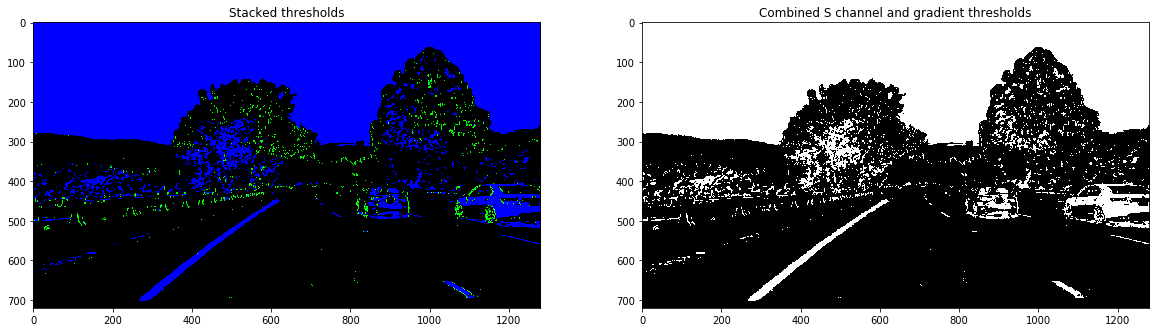

In [14]:
def img_binary(gray, s_channel):
    # Sobel x on gray scale
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient on gray scale
    thresh_min = 50
    thresh_max = 150
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Threshold S color channel
    s_thresh_min = 100
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    
    return color_binary, combined_binary

color_binary, combined_binary = img_binary(gray, s_channel)

# Plotting thresholded images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Stacked thresholds')
ax1.imshow(color_binary)

ax2.set_title('Combined S channel and gradient thresholds')
ax2.imshow(combined_binary, cmap='gray')

# Top down view

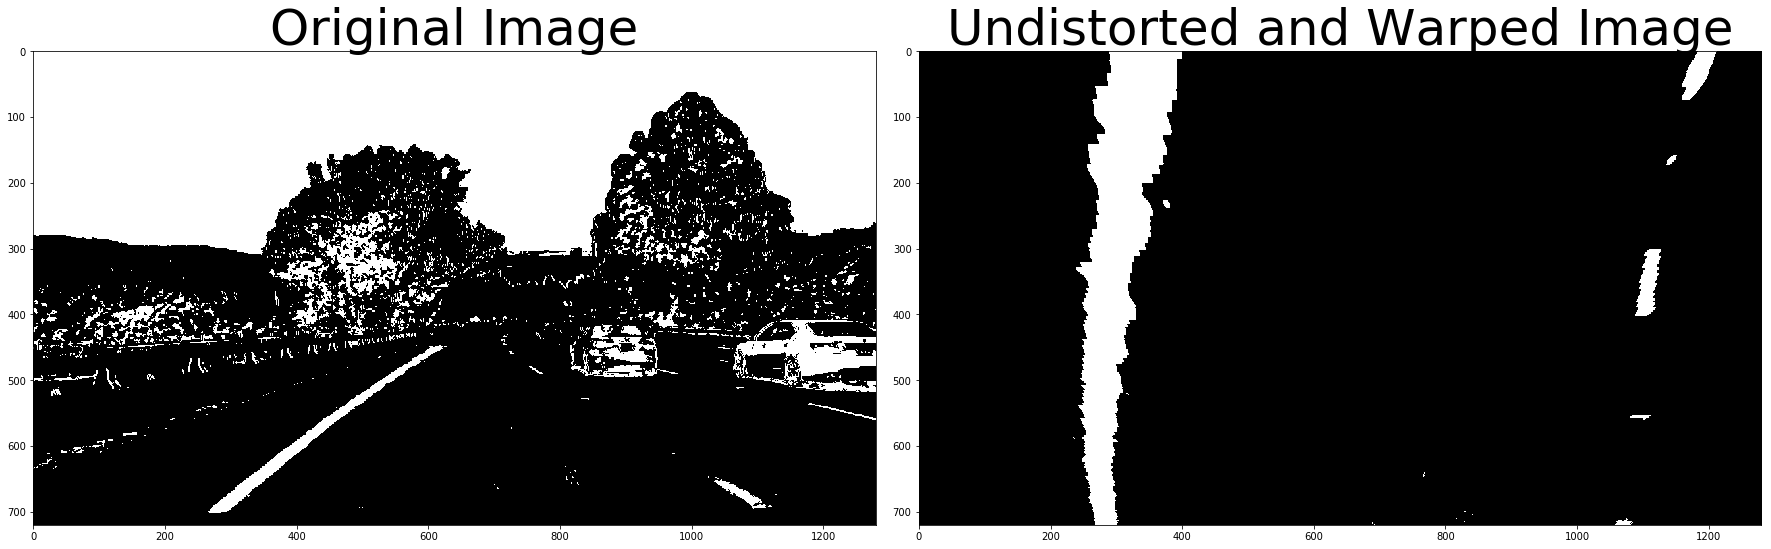

In [15]:
def corners_unwarp(img):
    img_size = (img.shape[1], img.shape[0])
    src = np.float32([[589,457], [700,457], [1016,665], [287,665]])
    offset = 100
    dst = np.float32([[250,0], [1020,0], [1020,img_size[1]], [250,img_size[1]]])
    M = cv2.getPerspectiveTransform(src, dst)
    top_down = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return top_down, M, src, dst

top_down, M, src, dst = corners_unwarp(combined_binary)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(combined_binary, cmap="gray")
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(top_down, cmap='gray')
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


## Detecting start of the lines with an histogram

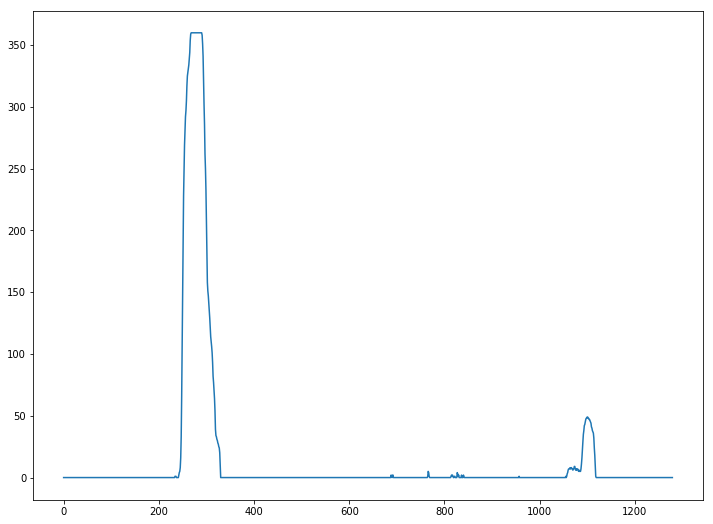

In [29]:
hist = np.sum(top_down[(top_down.shape[0]//2):,:], axis = 0)
plt.plot(hist)

We detect the left line starting around x = 400 and the right line around y = 950. We will then split in 2 the histogram and tahe the max arguments to get the position of the zones to track.

In [30]:
left_lanex = np.argmax(hist[:hist.shape[0]//2])
right_lanex = np.argmax(hist[hist.shape[0]//2:]) + hist.shape[0]//2

In [31]:
print("Left Lane starts at x = {}".format(left_lanex))
print("Right Lane starts at x = {}".format(right_lanex))


Left Lane starts at x = 268
Right Lane starts at x = 1100


Now we will draw boxes around these coordinates

In [32]:
def detect_lane_lines(binary_img) :
    
    hist = np.sum(binary_img[(binary_img.shape[0]//2):,:], axis = 0)
    left_lanex = np.argmax(hist[:hist.shape[0]//2])
    right_lanex = np.argmax(hist[hist.shape[0]//2:]) + hist.shape[0]//2

    #create RGB image from binary image to draw on

    binary_boxes = np.dstack((top_down, top_down, top_down))*255

    windows = 9
    window_width = 200
    window_heigth = top_down.shape[0] // windows
    min_pix = 100

    nonzero = binary_img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    # Current positions to be updated later for each window in nwindows
    leftx_current = left_lanex
    rightx_current = right_lanex
    leftx_change = 0
    rightx_change = 0

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    for window in range(windows):
        #identify the boxes y boundaries
        y_low = binary_boxes.shape[0] - window_heigth * (window + 1) 
        y_high = binary_boxes.shape[0] - window_heigth * window
        #identify the boxes x boundaries
        right_x_low = rightx_current - (window_width // 2)
        right_x_high = rightx_current + (window_width // 2)
        left_x_low = leftx_current - (window_width // 2)
        left_x_high = leftx_current + (window_width // 2)

        

        #draw boxes 
        cv2.rectangle(binary_boxes,(left_x_low,y_low),(left_x_high,y_high),(0,150,255), 2)
        cv2.rectangle(binary_boxes,(right_x_low,y_low),(right_x_high,y_high),(0,150,255), 2)

        #add pixel indexes in arrays
        
        left_box_indexes = ((nonzeroy >= y_low) & (nonzeroy < y_high) & (nonzerox >= left_x_low) & (nonzerox < left_x_high)).nonzero()[0]
        right_box_indexes = ((nonzeroy >= y_low) & (nonzeroy < y_high) & (nonzerox >= right_x_low) & (nonzerox < right_x_high)).nonzero()[0]

        #move the box if it contains more than 50 pixels
        #if it doesnt contain enough pixel, move it as much as last time
        if len(left_box_indexes) > min_pix :
            left_lane_inds.append(left_box_indexes)
            left_x_new = int(np.mean(nonzerox[left_box_indexes]))
            leftx_change = left_x_new - leftx_current
            leftx_current = int(np.mean(nonzerox[left_box_indexes]))
        else :
            leftx_current += leftx_change
            
        if len(right_box_indexes) > min_pix :
            right_lane_inds.append(right_box_indexes)
            right_x_new = int(np.mean(nonzerox[right_box_indexes]))
            rightx_change = right_x_new - rightx_current
            rightx_current = int(np.mean(nonzerox[right_box_indexes]))
        else:
            rightx_current += rightx_change

    if left_lane_inds != []:
        left_lane_inds = np.concatenate(left_lane_inds)
    if right_lane_inds != []:
        right_lane_inds = np.concatenate(right_lane_inds)


    #extract pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    return leftx, lefty, rightx, righty, binary_boxes

leftx, lefty, rightx, righty, binary_boxes= detect_lane_lines(top_down)

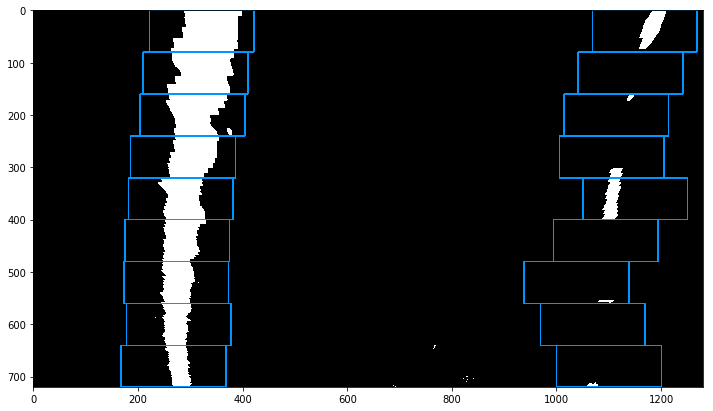

In [33]:
plt.imshow(binary_boxes)

Fit 2 polynomials with the extracted pixel coordinates

In [34]:
def fitx(fit, y=np.linspace(0, img.shape[0]-1, img.shape[0])): 
    a = fit[0]
    b = fit[1]
    c = fit[2]
    fitx = (a * (y **2)) + (b * y) + c
    return fitx

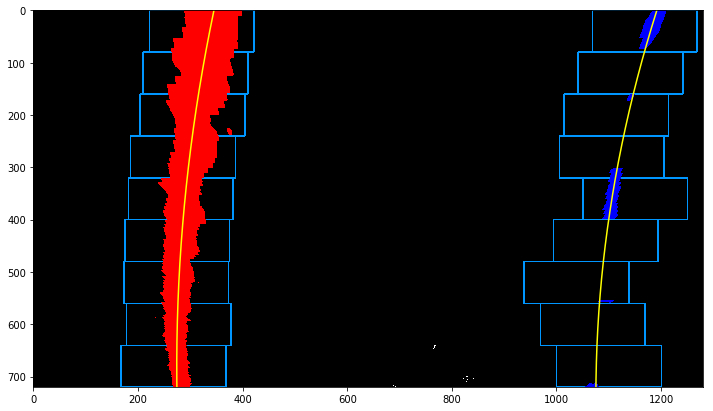

In [22]:
def fit_poly(img, lefty, leftx, righty, rightx) :
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    return left_fit, right_fit
    


def draw_poly(left_fit, right_fit):
    left_fitx = fitx(left_fit)

    right_fitx = fitx(right_fit)
    
    y = np.linspace(0, img.shape[0]-1, img.shape[0])
    
    return left_fitx, right_fitx, y

left_fit, right_fit = fit_poly(binary_boxes, lefty, leftx, righty, rightx)
left_fitx, right_fitx, y = draw_poly(left_fit, right_fit)

# Colors in the left and right lane regions
binary_boxes[lefty, leftx] = [255, 0, 0]
binary_boxes[righty, rightx] = [0, 0, 255]

# Plots the left and right polynomials on the lane lines
plt.imshow(binary_boxes)
plt.plot(left_fitx, y, color='yellow')
plt.plot(right_fitx, y, color='yellow')
plt.show()



# Detect next focus zone from polynomials

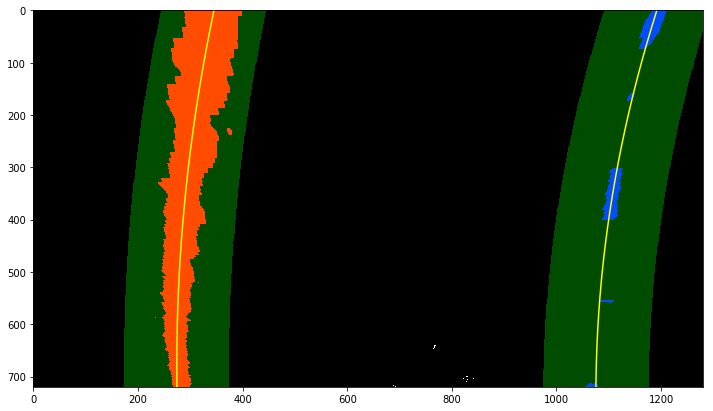

In [23]:
def search_around_poly(binary_warped, left_fit, right_fit ):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fit, right_fit  = fit_poly(top_down, lefty, leftx, righty, rightx)
    left_fitx, right_fitx, y = draw_poly(left_fit, right_fit)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, y]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              y])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, y]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              y])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    plt.plot(left_fitx, y, color='yellow')
    plt.plot(right_fitx, y, color='yellow')
    ## End visualization steps ##
    return left_fit, right_fit, left_fitx, right_fitx, y, result

# Run image through the pipeline
# Note that in your project, you'll also want to feed in the previous fits
left_fit, right_fit, left_fitx, right_fitx, y, result = search_around_poly(top_down, left_fit, right_fit)

# View your output
plt.imshow(result)

## Measuring lane size and curvature



In [24]:
def measure_curvature(right_fitx, left_fitx):
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/775 # meters per pixel in x dimension
    # Define y-value where we want radius of curvature
    #We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(y)
    ploty = np.linspace(0, 719, num=720)
    

    
    #fit again with conversion
    left_fit_cr = np.polyfit(ym_per_pix * ploty, left_fitx * xm_per_pix, 2)
    right_fit_cr = np.polyfit(ym_per_pix * ploty, right_fitx * xm_per_pix, 2)
    
     
    left_curverad = ((1 + (2 * left_fit_cr[0] * y_eval * ym_per_pix + left_fit_cr[1] )**2)**(3/2))/ abs(2 * left_fit_cr[0])
    right_curverad = ((1 + (2 * right_fit_cr[0] * y_eval * ym_per_pix + right_fit_cr[1] )**2)**(3/2))/ abs(2 * right_fit_cr[0])  ## Implement the calculation of the right line here
    
    return left_curverad, right_curverad


# Calculate the radius of curvature in pixels for both lane lines
left_curverad, right_curverad = measure_curvature(right_fitx, left_fitx)
print(left_curverad, right_curverad)

1185.55235469 849.506926762


In [25]:
def measure_distance(y, left_fit, right_fit):
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/775 # meters per pixel in x dimension
    
    leftx = fitx(left_fit, y)
    rightx = fitx(right_fit, y)
    distance = ((rightx - leftx) * xm_per_pix).round(2)
    return distance
    
    
low_distance = measure_distance(720, left_fit, right_fit)
high_distance = measure_distance(0, left_fit, right_fit)
print(low_distance, high_distance)

def center_to_lane(left_fit, right_fit):
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/775 # meters per pixel in x dimension
    leftx = fitx(left_fit, 720)
    rightx = fitx(right_fit, 720)
    lane_center = (leftx + rightx)/2
    offset = ((1280/2) - lane_center) * xm_per_pix
    return offset

offset = center_to_lane(left_fit, right_fit)
print(str(offset.round(2))+"m")
    

    


3.82 4.04
-0.17m


## Draw image

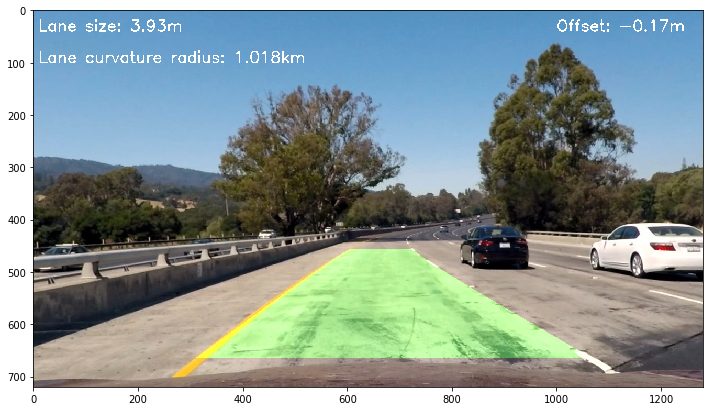

In [26]:
def draw_image(undist, warped_image, left_fitx, right_fitx, y, dst, src):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped_image).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, y]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, y])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Inverted warp
    Minv = cv2.getPerspectiveTransform(dst,src)
    newwarp = cv2.warpPerspective(color_warp, Minv, (warped_image.shape[1], warped_image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    

    return result
    
result = draw_image(undist, top_down, left_fitx, right_fitx, y, dst, src)
#add text
lane_size = str((low_distance + high_distance)/2)
cv2.putText(result, "Lane size: {}m".format(lane_size),(10,40), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2)
lane_curvature = str(((left_curverad + right_curverad) / 2000).round(3))
cv2.putText(result, "Lane curvature radius: {}km".format(lane_curvature),(10,100), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2)
offset = str(center_to_lane(left_fit, right_fit).round(2))
cv2.putText(result, "Offset: {}m".format(offset),(1000,40), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2)




plt.imshow(result)

In [27]:
road_images = glob.glob('./test_images/test*.jpg')



def lane_detection_pipeline(img):
    
    #define global variables
    global left_fit
    global right_fit
    global left_fitx
    global right_fitx
    global left_fitx_record
    global right_fitx_record
    
    
    undist = undistort_image(img, mtx, dist)
    s_channel, gray = convert_image(undist)
    color_binary, combined_binary = img_binary(gray, s_channel)
    top_down, M, src, dst = corners_unwarp(combined_binary)
    
    if left_fitx_record == [] or right_fitx_record == []:
        leftx, lefty, rightx, righty, binary_boxes = detect_lane_lines(top_down)
        #if no line detect, dot not plot anything
        if leftx != [] and lefty != [] and rightx != [] and righty != []:
            left_fit, right_fit = fit_poly(binary_boxes, lefty, leftx, righty, rightx)
        else :
            return undist
    else:
        left_fit, right_fit, left_fitx, right_fitx, y, result = search_around_poly(top_down, left_fit, right_fit)
        
    #Sanity Check
    low_distance = measure_distance(720, left_fit, right_fit)
    high_distance = measure_distance(0, left_fit, right_fit)
    # IF OK, append to fit_record, if not, try again with bouding boxes
    if low_distance < 4.5 and low_distance > 3 and high_distance < 4.5 and high_distance > 3 :
        left_fitx_record.append(left_fit)
        right_fitx_record.append(right_fit)
    else:
        leftx, lefty, rightx, righty, binary_boxes = detect_lane_lines(top_down)
        if leftx != [] and lefty != [] and rightx != [] and righty != []:
            left_fit, right_fit = fit_poly(binary_boxes, lefty, leftx, righty, rightx)
            #2nd sanity check
            low_distance = measure_distance(720, left_fit, right_fit)
            high_distance = measure_distance(0, left_fit, right_fit)
            if low_distance < 4.5 and low_distance > 3 and high_distance < 4.5 and high_distance > 3 :
                left_fitx_record.append(left_fit)
                right_fitx_record.append(right_fit)
                #if there is nothing in the record, return frame with no lane lines
            else:
                if left_fitx_record == [] or right_fitx_record == []:
                    return undist
                 
            
    
    #average last 5 fits
    right_fit = np.mean(right_fitx_record[-5:], axis=0)
    left_fit = np.mean(left_fitx_record[-5:], axis=0)
    #Draw lines
    left_fitx, right_fitx, y = draw_poly(left_fit, right_fit)
    result = draw_image(undist, top_down, left_fitx, right_fitx, y, dst, src)
    #Draw info
    lane_size = str((low_distance + high_distance)/2)
    cv2.putText(result, "Lane size: {}m".format(lane_size),(10,40), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2)
    
    left_curverad, right_curverad = measure_curvature(right_fitx, left_fitx)
    lane_curvature = str(((left_curverad + right_curverad) / 2000).round(3))
    cv2.putText(result, "Lane curvature radius: {}km".format(lane_curvature),(10,100), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255)
                ,2)
    offset = str(center_to_lane(left_fit, right_fit).round(2))
    cv2.putText(result, "Offset: {}m".format(offset),(1000,40), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2)
    
    return result
        
        
        

In [28]:
def pipeline_video(video_name):
    white_output = './output_' + video_name
    ## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
    ## To do so add .subclip(start_second,end_second) to the end of the line below
    ## Where start_second and end_second are integer values representing the start and end of the subclip
    ## You may also uncomment the following line for a subclip of the first 5 seconds
    ##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
    clip1 = VideoFileClip("./" + video_name)
    white_clip = clip1.fl_image(lane_detection_pipeline) #NOTE: this function expects color images!!
    %time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video ./output_project_video.mp4
[MoviePy] Writing video ./output_project_video.mp4


100%|█████████▉| 1260/1261 [04:30<00:00,  4.83it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_project_video.mp4 

CPU times: user 2min 7s, sys: 18.6 s, total: 2min 26s
Wall time: 4min 33s


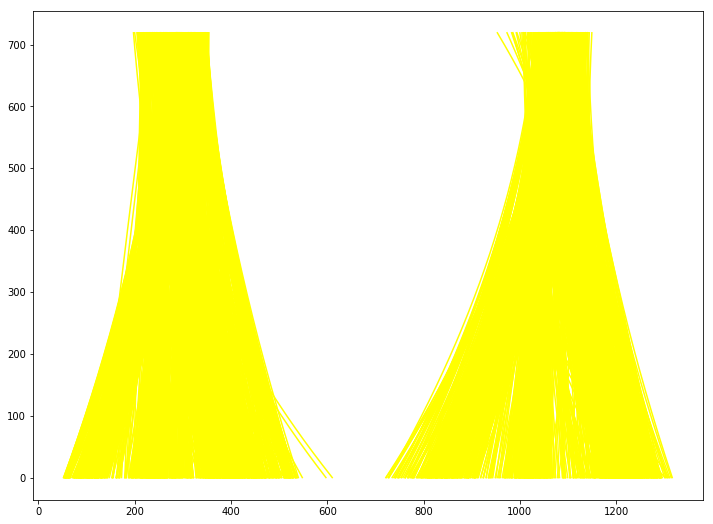

In [104]:
#define global variables
left_fit = []
right_fit = []
left_fitx = []
right_fitx = []
left_fitx_record = []
right_fitx_record = []

pipeline_video('project_video.mp4')

[MoviePy] >>>> Building video ./output_challenge_video.mp4
[MoviePy] Writing video ./output_challenge_video.mp4



 64%|██████▎   | 309/485 [01:00<00:36,  4.81it/s]


100%|██████████| 485/485 [01:36<00:00,  4.83it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_challenge_video.mp4 

CPU times: user 45.7 s, sys: 5.79 s, total: 51.5 s
Wall time: 1min 39s


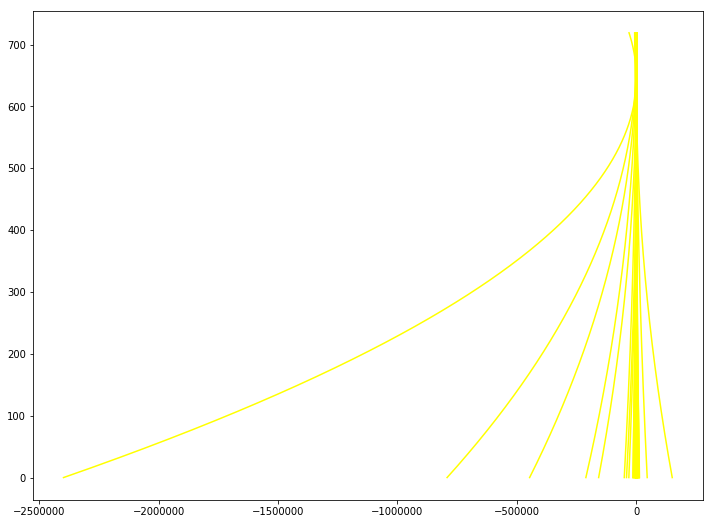

In [74]:
#reset global variables
left_fit = []
right_fit = []
left_fitx = []
right_fitx = []
left_fitx_record = []
right_fitx_record = []

pipeline_video('challenge_video.mp4')

In [ ]:
#reset global variables
left_fit = []
right_fit = []
left_fitx = []
right_fitx = []
left_fitx_record = []
right_fitx_record = []

pipeline_video('harder_challenge_video.mp4')

In [76]:
right_fitx_record = []
right_fitx_record.append([4,4,5])
right_fitx_record.append([4,4,2])
right_fitx_record.append([4,4,2])
right_fitx_record.append([4,4,2])
right_fitx_record[-4:-1]

[[4, 4, 5], [4, 4, 2], [4, 4, 2]]

In [77]:
np.mean(right_fitx_record[-4:-1], axis=0)

array([ 4.,  4.,  3.])